# BBM409: Introduction to Machine Learning Laboratory
## Assignment 3: Naive Bayes

## Atakan Yüksel 21627892
## Burak Özüesen 21827761

## Pre-processing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("./data/emails.csv")
df.head(3)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1


In [3]:
df["spam"] = df["spam"].astype("category")
df.dtypes

text      object
spam    category
dtype: object

In [4]:
df["spam"].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [5]:
df["text"] = df["text"].apply(lambda x: x[9:]) # remove 'Subject: ' from every text
df["text"] = df["text"].str.replace(r'[^\w\s]+', '') # remove punctuation
df["text"] = df["text"].apply(lambda x: x.lower()) # lowercase all characters

df.head(3)

,text,spam
0,naturally irresistible your corporate identity...,1
1,the stock trading gunslinger fanny is merrill...,1
2,unbelievable new homes made easy im wanting t...,1


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["spam"], test_size=0.2, shuffle=True, stratify=df["spam"], random_state=42)

train_df = pd.DataFrame()
train_df["text"] = X_train
train_df["spam"] = y_train

test_df = pd.DataFrame()
test_df["text"] = X_test
test_df["spam"] = y_test

## Bag-of-Words Implementation

In [7]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def build_bag_of_words(df, gram="unigram", filter_stopwords=False):
    bow = {}
    for item in df.tolist():
        tokens = item.split()
        if gram == "unigram":
            for token in tokens:
                if filter_stopwords: # remove stopwords
                    if token not in ENGLISH_STOP_WORDS:
                        try:
                            bow[token] += 1
                        except KeyError:
                            bow[token] = 1
                            continue
                else: # ignore stopwords
                    try:
                        bow[token] += 1
                    except KeyError:
                        bow[token] = 1
                        continue
        elif gram == "bigram":
            for idx, token in enumerate(tokens):
                try:
                    if filter_stopwords:
                        if token not in ENGLISH_STOP_WORDS and tokens[idx + 1] not in ENGLISH_STOP_WORDS:
                            bigram = token + " " + tokens[idx + 1]
                            try:
                                bow[bigram] += 1
                            except KeyError:
                                bow[bigram] = 1
                                continue
                    else:
                        bigram = token + " " + tokens[idx + 1]
                        try:
                            bow[bigram] += 1
                        except KeyError:
                            bow[bigram] = 1
                            continue
                except IndexError:
                    break
    return dict(sorted(bow.items(), reverse=True, key=lambda x: x[1]))

## Term Frequency - Inverse Document Frequency

In [8]:
def term_frequency(term, document): # frequency of a word in a sentence
    return document.count(term) / len(document)

In [9]:
from math import log # natural logarithm


def inverse_document_frequency(df):
    idf = {}
    for item in df.tolist():
        tokens = item.split()
        for token in list(set(tokens)): # set(tokens) makes sure that every word appears only once.
            try:
                idf[token] += 1
            except KeyError: # first time encounter with the word
                idf[token] = 1
    for key in idf:
        idf[key] = log(len(df.tolist()) / idf[key]) # idf formula
    return dict(sorted(idf.items(), reverse=True, key=lambda x: x[1]))

## Part 1

Classification using words that appear in the text is more than feasible and the main use case of Naive Bayes. The other alternative is to use Deep Learning or NLP models, which are way more computationally expensive. Below are 3 examples for both ham and spam mails. Note that stop words were removed.

3 words that appear the most on ham mails:

In [10]:
ham_bow = build_bag_of_words((df[df["spam"] == 0])["text"], filter_stopwords=True)

for word in list(ham_bow)[:3]:
    print("Word: '{}', appears {} times.".format(word, ham_bow[word]))

Word: 'enron', appears 13382 times.
Word: 'ect', appears 11417 times.
Word: 'vince', appears 8531 times.


3 words that appear the most on spam mails:

In [11]:
spam_bow = build_bag_of_words((df[df["spam"] == 1])["text"], filter_stopwords=True)

for word in list(spam_bow)[:3]:
    print("Word: '{}', appears {} times.".format(word, spam_bow[word]))

Word: '_', appears 13556 times.
Word: 's', appears 1333 times.
Word: 'com', appears 998 times.


## Part 2

Classification using Unigram BoW has much better accuracy than Bigram BoW. Note that stopwords were not filtered in both cases. Stopword effect will be examined in Part 3 and Part 4.

In [12]:
from sklearn.metrics import  classification_report

### Naive Bayes Implementation

In [13]:
from math import log10
from sklearn.feature_extraction.text import CountVectorizer

def naive_bayes(train_df, test_df, gram="unigram", filter_stopwords=False, tfidf=False):
    ham_series = (train_df[train_df["spam"] == 0])["text"] # pandas series with ham mails
    spam_series = (train_df[train_df["spam"] == 1])["text"] # pandas series with spam mails

    ham_bow = build_bag_of_words(ham_series, gram=gram, filter_stopwords=filter_stopwords) # ham mail bow
    spam_bow = build_bag_of_words(spam_series, gram=gram, filter_stopwords=filter_stopwords) # spam mail bow

    p_ham = train_df["spam"].value_counts()[0] / sum(train_df["spam"].value_counts()) # naive bayes rule, first term is percentage of the class to predict
    p_spam = train_df["spam"].value_counts()[1] / sum(train_df["spam"].value_counts()) # naive bayes rule, first term is percentage of the class to predict

    ham_idf = inverse_document_frequency(ham_series) # IDF dictionary that contains idf values for ham mail words
    spam_idf = inverse_document_frequency(spam_series) # IDF dictionary that contains idf values for spam mail words


    y_pred = []

    for idx, row in test_df.iterrows(): # for every row on test_df
        # tokens = row["text"].split()
        bigrams = []
        
        if gram == "unigram":
            tokens = row["text"].split()
        
        else:
            tokens = row["text"].split()
            for i in range(len(tokens)-1):
                bigrams.append(tokens[i] + " " + tokens[i+1])
            tokens = bigrams
        
        log_total = [log10(p_ham), log10(p_spam)] # log_total[0] is ham, log_total[1] is spam
       
        if not tfidf:
            for i in tokens: # ham
                try:
                    log_total[0] += log10(ham_bow[i]/len(ham_bow)) # how many times the word appeared divided by length of the ham corpus
                except KeyError: # need laplace smoothing
                    log_total[0] += log10(1/(len(ham_bow) + len(tokens)))
                    continue
            for i in tokens: # spam
                try:
                    log_total[1] += log10(spam_bow[i]/len(spam_bow)) # how many times the word appeared divided by length of the spam corpus
                except KeyError: # need laplace smoothing
                    log_total[1] += log10(1/(len(spam_bow) + len(tokens)))
                    continue
            y_pred.append(np.argmax(log_total)) # returns the index of the larger value. 0 for ham and 1 for spam.
        else: # tfidf
            for token in tokens: # ham
                try:
                    log_total[0] += log10((term_frequency(token, tokens) * ham_idf[token] * ham_bow[token]) / len(ham_bow)) # Term Frequency * Inverse Document Frequency
                except KeyError: # need laplace smoothing
                    log_total[0] += log10(1/(len(ham_bow) + len(tokens)))
                    continue
            for token in tokens: # spam
                try:
                    log_total[1] += log10((term_frequency(token, tokens) * spam_idf[token] * spam_bow[token]) / len(spam_bow)) # Term Frequency * Inverse Document Frequency
                except KeyError:  # need laplace smoothing
                    log_total[1] += log10(1/(len(spam_bow) + len(tokens)))
                    continue
            y_pred.append(np.argmax(log_total))
        
    return y_pred

### Classification using Unigram BoW

Classification using Unigram BoW without removing stopwords has 84% accuracy.

In [14]:
unigram_y_pred = naive_bayes(train_df, test_df)
print(classification_report(y_test, unigram_y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       872
           1       1.00      0.32      0.49       274

    accuracy                           0.84      1146
   macro avg       0.91      0.66      0.69      1146
weighted avg       0.87      0.84      0.80      1146



### Classification using Bigram BoW

Classification using Bigram BoW without removing stopwords has 24% accuracy.

In [15]:
bigram_y_pred = naive_bayes(train_df, test_df, gram="bigram")
print(classification_report(y_test, bigram_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       872
           1       0.75      1.00      0.86       274

    accuracy                           0.92      1146
   macro avg       0.88      0.95      0.90      1146
weighted avg       0.94      0.92      0.93      1146



In [16]:
bigram_y_pred = pd.DataFrame(bigram_y_pred)
print(pd.DataFrame(unigram_y_pred).value_counts())
print(bigram_y_pred.value_counts())
print(test_df["spam"].value_counts())
print(train_df["spam"].value_counts())
y_test.value_counts()

0    1058
1      88
dtype: int64
0    783
1    363
dtype: int64
0    872
1    274
Name: spam, dtype: int64
0    3488
1    1094
Name: spam, dtype: int64


0    872
1    274
Name: spam, dtype: int64

## Part 3

In [17]:
ham_bow = build_bag_of_words((df[df["spam"] == 0])["text"])
spam_bow = build_bag_of_words((df[df["spam"] == 1])["text"])

ham_bow_without_stopwords = build_bag_of_words((df[df["spam"] == 0])["text"], filter_stopwords=True)
spam_bow_without_stopwords = build_bag_of_words((df[df["spam"] == 1])["text"], filter_stopwords=True)

### (a) Analyzing effect of the words on prediction

#### 1. List the 10 words whose presence most strongly predicts that the mail is ham.

In [18]:
for word in list(ham_bow)[:10]:
    print("Word: '{}', appears {} times.".format(word, ham_bow[word]))

Word: 'the', appears 41135 times.
Word: 'to', appears 33571 times.
Word: 'and', appears 20961 times.
Word: 'of', appears 18128 times.
Word: 'i', appears 15649 times.
Word: 'a', appears 15250 times.
Word: 'you', appears 14234 times.
Word: 'in', appears 14096 times.
Word: 'for', appears 13510 times.
Word: 'enron', appears 13382 times.


#### 2. List the 10 words whose absence most strongly predicts that the mail is ham.

In [19]:
spam_absence = {}
for i in spam_bow:
    try:
        spam_absence[i] = spam_bow[i] - ham_bow[i] # words with the highest occurance in spam_bow and lowest occurance in ham_bow
    except KeyError: # word does not exist in spam_bow and ham_bow at the same time
        try: # word still may exist in spam_bow
            spam_absence[i] = spam_bow[i]
        except KeyError:
            continue
        continue

spam_absence = dict(sorted(spam_absence.items(), reverse=True, key=lambda x: x[1]))

for word in list(spam_absence)[:10]:
    print("Word: '{}', appears {} times.".format(word, spam_absence[word]))

Word: '_', appears 9878 times.
Word: 'money', appears 549 times.
Word: 'adobe', appears 448 times.
Word: '2005', appears 369 times.
Word: 'click', appears 331 times.
Word: 'statements', appears 295 times.
Word: 'website', appears 281 times.
Word: 'life', appears 240 times.
Word: 'save', appears 220 times.
Word: 'account', appears 193 times.


#### 3. List the 10 words whose presence most strongly predicts that the mail is spam.

In [20]:
for word in list(spam_bow)[:10]:
    print("Word: '{}', appears {} times.".format(word, spam_bow[word]))

Word: '_', appears 13556 times.
Word: 'the', appears 8975 times.
Word: 'to', appears 8165 times.
Word: 'and', appears 6517 times.
Word: 'of', appears 5629 times.
Word: 'you', appears 4920 times.
Word: 'a', appears 4695 times.
Word: 'in', appears 3879 times.
Word: 'your', appears 3730 times.
Word: 'for', appears 3186 times.


#### 4. List the 10 words whose absence most strongly predicts that the mail is spam.

In [21]:
ham_absence = {}
for i in ham_bow:
    try:
        ham_absence[i] = ham_bow[i] - spam_bow[i] # words with the highest occurance in ham_bow and lowest occurance in spam_bow
    except KeyError: # word does not exist in spam_bow and ham_bow at the same time
        try: # word still may exist in ham_bow
            ham_absence[i] = ham_bow[i]
        except KeyError:
            continue
        continue

ham_absence = dict(sorted(ham_absence.items(), reverse=True, key=lambda x: x[1]))

for word in list(ham_absence)[:10]:
    print("Word: '{}', appears {} times.".format(word, ham_absence[word]))

Word: 'the', appears 32160 times.
Word: 'to', appears 25406 times.
Word: 'and', appears 14444 times.
Word: 'i', appears 13877 times.
Word: 'enron', appears 13382 times.
Word: 'of', appears 12499 times.
Word: 'ect', appears 11416 times.
Word: 'a', appears 10555 times.
Word: 'for', appears 10324 times.
Word: 'in', appears 10217 times.


#### TFIDF

In [22]:
tfidf_pred = naive_bayes(train_df, test_df, tfidf=True)
print(classification_report(y_test, tfidf_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       872
           1       0.93      0.19      0.32       274

    accuracy                           0.80      1146
   macro avg       0.86      0.59      0.60      1146
weighted avg       0.83      0.80      0.75      1146



### (b) Stopwords

In [23]:
print(y_test.value_counts())
print(pd.DataFrame(tfidf_pred).value_counts())

0    872
1    274
Name: spam, dtype: int64
0    1089
1      57
dtype: int64


#### 1. List the 10 words whose presence most strongly predicts that the mail is ham.

In [24]:
for word in list(ham_bow_without_stopwords)[:10]:
    print("Word: '{}', appears {} times.".format(word, ham_bow_without_stopwords[word]))

Word: 'enron', appears 13382 times.
Word: 'ect', appears 11417 times.
Word: 'vince', appears 8531 times.
Word: 'hou', appears 5569 times.
Word: 's', appears 5173 times.
Word: '2000', appears 4935 times.
Word: 'kaminski', appears 4770 times.
Word: 'com', appears 4444 times.
Word: 'subject', appears 4245 times.
Word: 'cc', appears 3889 times.


#### 2. List the 10 words whose presence most strongly predicts that the mail is spam.

In [25]:
for word in list(spam_bow_without_stopwords)[:10]:
    print("Word: '{}', appears {} times.".format(word, spam_bow_without_stopwords[word]))

Word: '_', appears 13556 times.
Word: 's', appears 1333 times.
Word: 'com', appears 998 times.
Word: '1', appears 952 times.
Word: 'business', appears 844 times.
Word: 'company', appears 805 times.
Word: 'email', appears 804 times.
Word: 'information', appears 740 times.
Word: 'e', appears 698 times.
Word: '5', appears 687 times.


### (c) Analyzing effect of the stopwords

We should definitely remove stopwords as it increases accuracy a lot.

#### Unigram BoW without Stopwords

Without removing stopwords, accuracy was 84%. Now it is 97%.

In [26]:
unigram_y_pred_without_stopwords = naive_bayes(train_df, test_df, filter_stopwords=True)
print(classification_report(y_test, unigram_y_pred_without_stopwords))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       872
           1       1.00      0.88      0.94       274

    accuracy                           0.97      1146
   macro avg       0.98      0.94      0.96      1146
weighted avg       0.97      0.97      0.97      1146



#### Bigram BoW without Stopwords

Bigram accuracy was low before removing the stopwords. It is still low, 24%.

In [27]:
bigram_y_pred_without_stopwords = naive_bayes(train_df, test_df, gram="bigram", filter_stopwords=True)
print(classification_report(y_test, bigram_y_pred_without_stopwords))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39       872
           1       0.29      1.00      0.45       274

    accuracy                           0.42      1146
   macro avg       0.65      0.62      0.42      1146
weighted avg       0.83      0.42      0.40      1146



## Part 4

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [29]:
def plot_cf(cf_matrix):
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

Performance Metrics were presented in the sections before. Overall best model is Unigram BoW without Stopwords. Bigram results are awful. But we present both for you to see.

ex. "hello my name is inigo montoya"<br>
unigram = ["hello", "my", "name", "is", "inigo", "montoya"]<br>
bigram = ["hello my", "my name", "name is", "is inigio", "inigo montoya"]<br>

#### Unigram BoW

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       872
           1       1.00      0.32      0.49       274

    accuracy                           0.84      1146
   macro avg       0.91      0.66      0.69      1146
weighted avg       0.87      0.84      0.80      1146



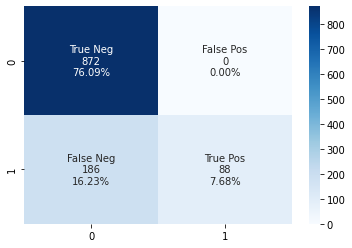

In [30]:
print(classification_report(y_test, unigram_y_pred))
plot_cf(confusion_matrix(y_test, unigram_y_pred))

#### Unigram BoW without Stopwords

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       872
           1       1.00      0.88      0.94       274

    accuracy                           0.97      1146
   macro avg       0.98      0.94      0.96      1146
weighted avg       0.97      0.97      0.97      1146



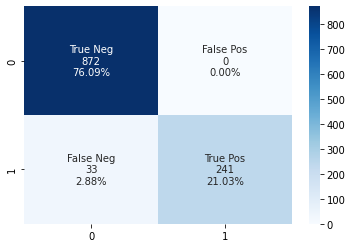

In [31]:
print(classification_report(y_test, unigram_y_pred_without_stopwords))
plot_cf(confusion_matrix(y_test, unigram_y_pred_without_stopwords))

#### Bigram BoW

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       872
           1       0.75      1.00      0.86       274

    accuracy                           0.92      1146
   macro avg       0.88      0.95      0.90      1146
weighted avg       0.94      0.92      0.93      1146



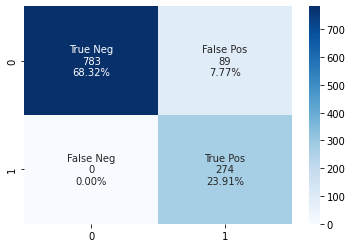

In [32]:
print(classification_report(y_test, bigram_y_pred))
plot_cf(confusion_matrix(y_test, bigram_y_pred))

#### Bigram BoW without Stopwords

              precision    recall  f1-score   support

           0       1.00      0.24      0.39       872
           1       0.29      1.00      0.45       274

    accuracy                           0.42      1146
   macro avg       0.65      0.62      0.42      1146
weighted avg       0.83      0.42      0.40      1146



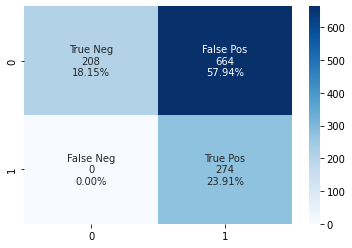

In [33]:
print(classification_report(y_test, bigram_y_pred_without_stopwords))
plot_cf(confusion_matrix(y_test, bigram_y_pred_without_stopwords))

#### TF-IDF

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       872
           1       0.93      0.19      0.32       274

    accuracy                           0.80      1146
   macro avg       0.86      0.59      0.60      1146
weighted avg       0.83      0.80      0.75      1146



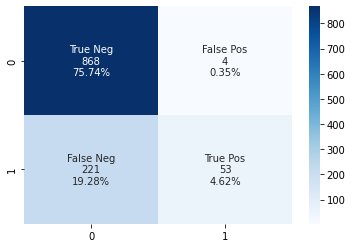

In [34]:
print(classification_report(y_test, tfidf_pred))
plot_cf(confusion_matrix(y_test, tfidf_pred))